In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
from shapely.affinity import translate, rotate
from shapely.strtree import STRtree
import random
from tqdm import tqdm
import math

class ChristmasTree:
    def __init__(self, center=(0, 0), angle=0):
        self.center = center
        self.angle = angle
        # Define the vertices of the Christmas tree polygon relative to (0,0)
        # Extracted from the research notebook
        tw=0.15; th=0.2; bw=0.7; mw=0.4; ow=0.25
        tip=0.8; t1=0.5; t2=0.25; base=0.0; tbot=-th
        x=np.array([0,ow/2,ow/4,mw/2,mw/4,bw/2,tw/2,tw/2,-tw/2,-tw/2,-bw/2,-mw/4,-mw/2,-ow/4,-ow/2],np.float64)
        y=np.array([tip,t1,t1,t2,t2,base,base,tbot,tbot,base,base,t2,t2,t1,t1],np.float64)
        self.vertices = list(zip(x, y))
        
        self.poly = Polygon(self.vertices)
        self.update_poly()

    def update_poly(self):
        # Re-create polygon from base vertices
        self.poly = Polygon(self.vertices)
        # Rotate
        self.poly = rotate(self.poly, self.angle, origin=(0, 0), use_radians=False)
        # Translate
        self.poly = translate(self.poly, self.center[0], self.center[1])

    def set_pose(self, x, y, angle):
        self.center = (x, y)
        self.angle = angle
        self.update_poly()

    def get_poly(self):
        return self.poly

def plot_results(trees, n, side):
    fig, ax = plt.subplots(figsize=(5, 5))
    for tree in trees:
        x, y = tree.get_poly().exterior.xy
        ax.fill(x, y, alpha=0.5)
    
    # Draw bounding box
    rect = plt.Rectangle((-side/2, -side/2), side, side, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    ax.set_aspect('equal')
    plt.title(f"N={n}, Side={side:.4f}")
    plt.show()

def calculate_score(side, n):
    return (side**2) / n

print("ChristmasTree class defined with correct vertices.")


ChristmasTree class defined with correct vertices.


Solving for N=1...
  Best side: 1.0000


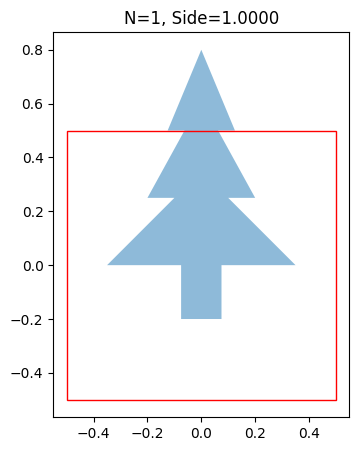

Solving for N=2...
  Best side: 1.1732


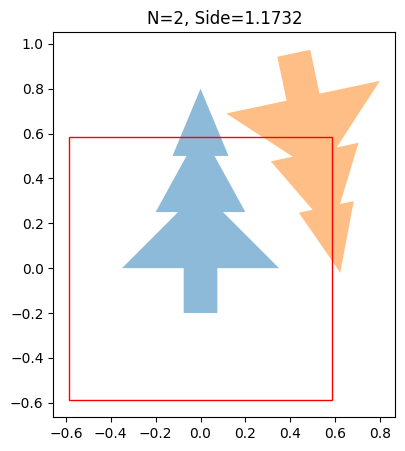

Solving for N=3...
  Best side: 1.8029


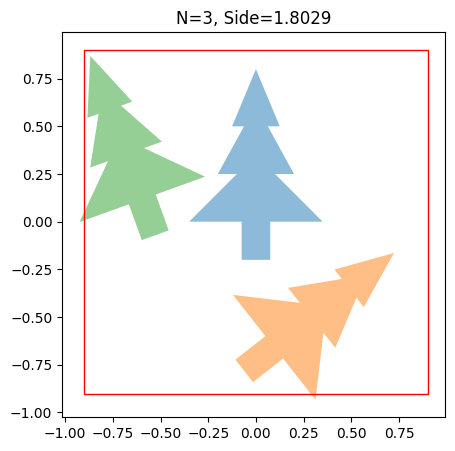

In [3]:
def solve_greedy(n, num_trials=100):
    best_trees = []
    best_side = float('inf')
    
    for _ in range(num_trials):
        current_trees = []
        # Place first tree at (0,0)
        t1 = ChristmasTree((0, 0), 0)
        current_trees.append(t1)
        
        valid_packing = True
        
        for i in range(1, n):
            placed = False
            # Try to place the next tree
            # Heuristic: try random positions within a growing radius
            # For efficiency, we can try to place it close to existing trees
            
            # Simple random trial
            for _ in range(50): # 50 attempts per tree
                # Random angle
                angle = random.uniform(0, 360)
                # Random position. 
                # Heuristic: pick an existing tree, add a random offset
                ref_tree = random.choice(current_trees)
                dist = random.uniform(0.5, 2.0) # Adjust based on tree size ~1.0
                theta = random.uniform(0, 2*math.pi)
                x = ref_tree.center[0] + dist * math.cos(theta)
                y = ref_tree.center[1] + dist * math.sin(theta)
                
                new_tree = ChristmasTree((x, y), angle)
                
                # Check overlap
                overlap = False
                for t in current_trees:
                    if new_tree.get_poly().intersects(t.get_poly()):
                        overlap = True
                        break
                
                if not overlap:
                    current_trees.append(new_tree)
                    placed = True
                    break
            
            if not placed:
                valid_packing = False
                break
        
        if valid_packing:
            # Calculate bounding box
            min_x = min([t.get_poly().bounds[0] for t in current_trees])
            max_x = max([t.get_poly().bounds[2] for t in current_trees])
            min_y = min([t.get_poly().bounds[1] for t in current_trees])
            max_y = max([t.get_poly().bounds[3] for t in current_trees])
            
            side = max(max_x - min_x, max_y - min_y)
            
            if side < best_side:
                best_side = side
                best_trees = current_trees
                
    return best_trees, best_side

# Test for N=1 to 3
results = {}
for n in range(1, 4):
    print(f"Solving for N={n}...")
    trees, side = solve_greedy(n, num_trials=50)
    if trees:
        results[n] = (trees, side)
        print(f"  Best side: {side:.4f}")
        plot_results(trees, n, side)
    else:
        print("  Failed to find solution")


In [4]:
def create_submission(results, sample_sub_path, output_path):
    sample_df = pd.read_csv(sample_sub_path)
    
    # Create a dictionary for fast lookup
    # Key: id, Value: (x, y, deg)
    updates = {}
    
    for n, (trees, side) in results.items():
        # We need to center the packing in the bounding box? 
        # The problem asks to minimize the square side. The absolute position doesn't matter, 
        # but usually we center it at (0,0) or just report coordinates.
        # The metric is side^2 / n.
        # The coordinates must be valid.
        
        # Let's just use the coordinates we found.
        for i, tree in enumerate(trees):
            row_id = f"{n:03d}_{i}" # e.g. 001_0, 002_0
            # Check if this id exists in sample (it should)
            updates[row_id] = (tree.center[0], tree.center[1], tree.angle)
            
    # Update dataframe
    new_rows = []
    for index, row in sample_df.iterrows():
        rid = row['id']
        if rid in updates:
            x, y, deg = updates[rid]
            new_rows.append({'id': rid, 'x': f"s{x}", 'y': f"s{y}", 'deg': f"s{deg}"})
        else:
            new_rows.append(row)
            
    submission_df = pd.DataFrame(new_rows)
    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")

# Run for N=1 to 5
results_5 = {}
for n in range(1, 6):
    print(f"Solving for N={n}...")
    trees, side = solve_greedy(n, num_trials=100) # Increase trials slightly
    if trees:
        results_5[n] = (trees, side)
        print(f"  Best side: {side:.4f}")

create_submission(results_5, '/home/data/sample_submission.csv', '/home/submission/submission.csv')


Solving for N=1...
  Best side: 1.0000
Solving for N=2...
  Best side: 1.1489
Solving for N=3...
  Best side: 1.6442
Solving for N=4...
  Best side: 1.9307
Solving for N=5...
  Best side: 2.3944


Submission saved to /home/submission/submission.csv


In [5]:
def calculate_submission_score(submission_path):
    df = parse_submission(submission_path)
    total_score = 0
    
    # Group by problem N
    # The ID format is NNN_i
    df['N'] = df['id'].apply(lambda x: int(x.split('_')[0]))
    
    # We need the vertices to calculate the bounding box for each N
    # Re-use the ChristmasTree class
    
    # Pre-compute template vertices
    # We can just instantiate one tree and get vertices
    template_tree = ChristmasTree()
    template_poly = template_tree.get_poly()
    
    for n in sorted(df['N'].unique()):
        group = df[df['N'] == n]
        
        # Reconstruct trees
        trees = []
        for _, row in group.iterrows():
            t = ChristmasTree((row['x'], row['y']), row['deg'])
            trees.append(t)
            
        # Calculate bounding box
        if not trees:
            continue
            
        min_x = min([t.get_poly().bounds[0] for t in trees])
        max_x = max([t.get_poly().bounds[2] for t in trees])
        min_y = min([t.get_poly().bounds[1] for t in trees])
        max_y = max([t.get_poly().bounds[3] for t in trees])
        
        side = max(max_x - min_x, max_y - min_y)
        
        term = (side**2) / n
        total_score += term
        
    return total_score

score = calculate_submission_score('/home/submission/submission.csv')
print(f"Total Score: {score:.4f}")


Total Score: 173.6881
